In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime

In [2]:
def values_from_database():
    return pd.read_pickle("stocks_values_pivot")

In [3]:
def change_day_month(date_string):
    return date_string[3:5] + "-" + date_string[:2] + "-" + date_string[-4:]

In [4]:
def value_stock(stock_name, date_start, 
                end_date = datetime.datetime.today().strftime("%d-%m-%Y")):
    
    
    values = values_from_database()
    stock_values = pd.DataFrame(values[stock_name])
    stock_values.columns = ["HGDG_KAPANIS"]
    
    date_start = datetime.datetime.strptime(date_start, "%d-%m-%Y")
    
    end_date = change_day_month(end_date)

    values = stock_values.loc[(stock_values.index > date_start) &
                            (stock_values.index < end_date)]
    
    values = values.sort_index()
    
    return values

In [5]:
def gain_loss(stock_name, date_start, 
                end_date = datetime.datetime.today().strftime("%d-%m-%Y")):
    
    stock = value_stock(stock_name, date_start, end_date) # use this function to get values
    stock["Change"] = stock["HGDG_KAPANIS"].diff() # get difference on new column
    
    def positive(value):
        return max(value, 0) # get positive values, otherwise zero

    def negative(value):
        return min(value, 0) # get negative values, otherwise zero
    
    stock["Gain"] = stock["Change"].map(positive) # create a column for gains
    stock["Loss"] = stock["Change"].map(negative) # create a column for losses
    
    return stock

In [6]:
def RS(values, row, dayRSI):
    gainsAvg = values.iloc[row-dayRSI:row,:]["Gain"].sum() / dayRSI 
        # ilgili satırdaki değeri referans alarak, belirtilen gün kadar geriye giderek POZİTİF değerleri alıp ortalamasını alacak
    lossesAvg = abs(values.iloc[row-dayRSI:row,:]["Loss"].sum()) / dayRSI
        # ilgili satırdaki değeri referans alarak, belirtilen gün kadar geriye giderek NEGATİF değerleri alıp ortalamasını alacak
    RS = gainsAvg/lossesAvg
        # rs için pozitiflerin, negatife oranı.
    return RS  

In [7]:
def RSI(rs):
    return 100-(100/(1+rs))

In [8]:
def RS_series(values, dayRSI):
    series = []
    for row in range(values.shape[0]-dayRSI+1):
        reference_row = int(row + dayRSI)
        rs = RS(values, reference_row, dayRSI)
        series.append(rs)
        
    elements = [0] * (dayRSI-1)
    series = elements + series
    
    values["RS"] = series
    
    return values

In [9]:
def RSI_frame(values, dayRSI):
    values = RS_series(values, dayRSI)
    values["RSI"] = values["RS"].map(RSI)
    return values

In [10]:
def RSI_indicator(stock_name:str, dayRSI, date_start, end_date= datetime.datetime.today().strftime("%d-%m-%Y")):
    stock_values = gain_loss(stock_name, date_start, end_date)
    RSI = RSI_frame(stock_values, dayRSI)
    return RSI

In [17]:
RSI_indicator("BIMAS", 14, "31-05-2019")

,HGDG_KAPANIS,Change,Gain,Loss,RS,RSI
HGDG_TARIH,,,,,,
2019-06-03,39.3893,NaN,NaN,NaN,0.000000,0.000000
2019-06-07,40.3987,1.0094,1.0094,0.0000,0.000000,0.000000
2019-06-10,39.5124,-0.8863,0.0000,-0.8863,0.000000,0.000000
2019-06-11,38.7000,-0.8124,0.0000,-0.8124,0.000000,0.000000
2019-06-12,39.3000,0.6000,0.6000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...
2020-05-22,63.2000,1.3000,1.3000,0.0000,2.033874,67.038844
2020-05-27,62.8000,-0.4000,0.0000,-0.4000,2.454043,71.048418
2020-05-28,61.7000,-1.1000,0.0000,-1.1000,2.643048,72.550457


In [18]:
def plot_RSI(stock_name:str, dayRSI, date_start, end_date= datetime.datetime.today().strftime("%d-%m-%Y")):
    RSI = RSI_indicator(stock_name, dayRSI, date_start, end_date)
    ax = RSI["RSI"].plot.line(figsize=(30,5))
    plt.axhline(30, color="gray")
    plt.axhline(70, color="gray")
    return ax

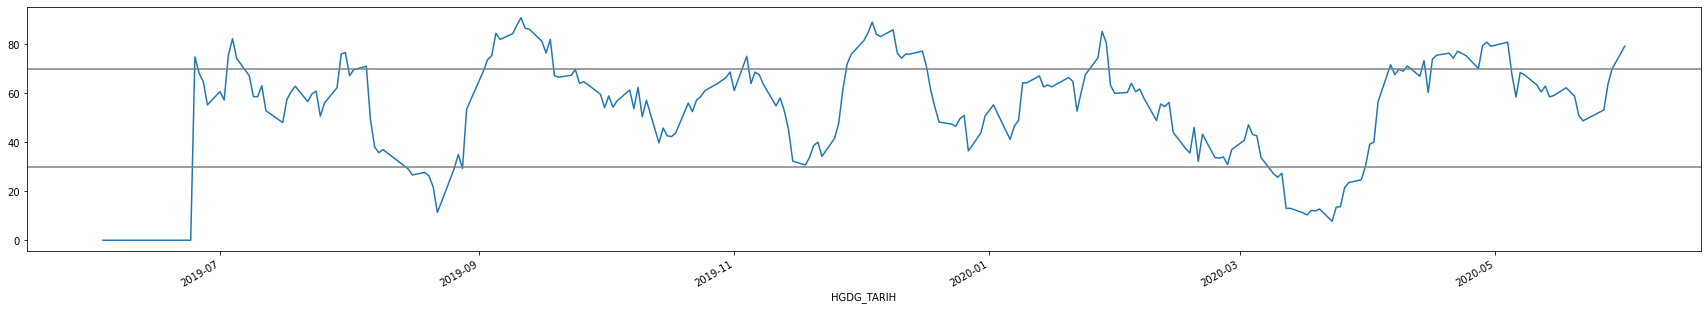

In [23]:
plot_RSI("CIMSA", 14, "31-05-2019")